# Making a Short-Time $\Phi_{\frac{5}{8}}$ transform for GW150914

## Imports

In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

# mbank imports
from mbank import variable_handler, cbc_metric, cbc_bank
from mbank.utils import load_PSD, plot_tiles_templates, get_boundaries_from_ranges
from mbank.placement import place_random_flow
from mbank.flow import STD_GW_Flow
from mbank.flow.utils import early_stopper, plot_loss_functions

# pycbc imports
from pycbc.waveform import get_td_waveform, get_fd_waveform, td_approximants, fd_approximants
from pycbc.noise.gaussian import frequency_noise_from_psd
import pycbc.types 

# gwpy imports
from gwpy.table import GravitySpyTable
from gwpy.timeseries import TimeSeries, TimeSeriesDict
from gwpy.frequencyseries import FrequencySeries
from gwpy.plot import Plot
from gwosc.datasets import event_gps
import gwpy

# non-CBC imports
from tqdm.notebook import tqdm
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

# dpt imports
from dpt.transform import STPT, ISTPT

## Script - Signal Processing with GW150914

In [2]:
gpsTime = event_gps('GW150914')
gwEvent = TimeSeries.fetch_open_data('H1', gpsTime - 8, gpsTime + 8, verbose=True)

Fetched 1 URLs from gwosc.org for [1126259454 .. 1126259471))
Reading data... [Done]


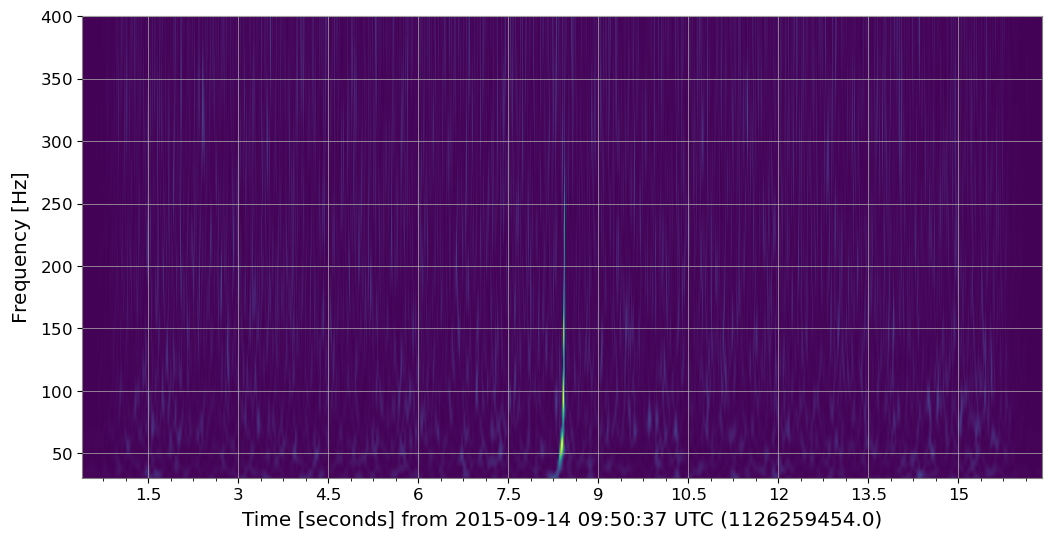

In [3]:
fig = gwEvent.q_transform(frange=(30, 400), qrange=(10, 30)).plot()

## Time series of the data 

In [4]:
filteredEvent = gwEvent.whiten().to_pycbc().highpass_fir(frequency=30, order=128)
strainData    = filteredEvent.data
fs            = filteredEvent.get_sample_rate()
times         = filteredEvent.get_sample_times()

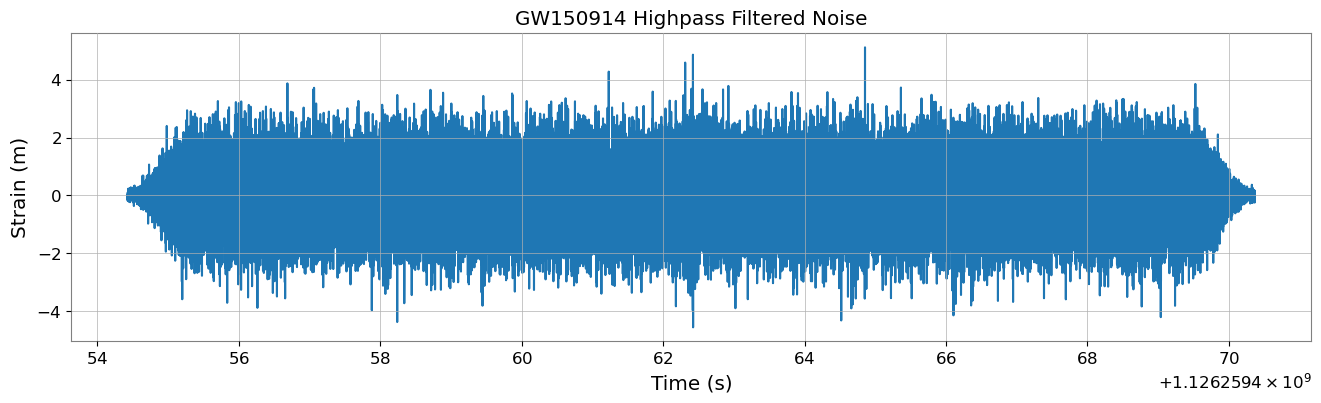

In [5]:
plt.figure(figsize=(16, 4))
plt.title("GW150914 Highpass Filtered Noise")
plt.plot(times, strainData)
plt.xlabel("Time (s)")
plt.ylabel("Strain (m)")
plt.show()

### Short-Time $\Phi_n$ Transform Construction

In [6]:
# Parameters for the system
n = 5 / 8
n_frequency     = np.arange(0, 2 ** 15, 2 ** 5)
window_duration = .5 # Seconds
window_size     = int(window_duration * fs) 
stpt            = STPT(n, fs, n_frequency, window_size) 

Constructing S Matrix (Chirp Order 0.6250): 100%|█| 1024/1024 [00:32<0


In [7]:
timeFreqSignal, n_frequency = stpt.transform(strainData)

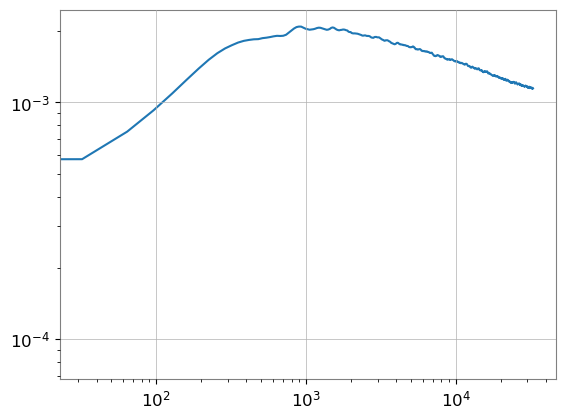

In [8]:
asdNoise = np.median(np.abs(timeFreqSignal), axis=1)
plt.loglog(n_frequency, asdNoise)

In [9]:
whitenedTFSignal = timeFreqSignal / asdNoise[:, np.newaxis]

In [10]:
# Compute power matrix
powerMatrix = np.abs(whitenedTFSignal) ** 2

# Find index of maximum power
max_idx_flat = np.argmax(powerMatrix)
max_idx_2d = np.unravel_index(max_idx_flat, powerMatrix.shape)

# Convert to NumPy if needed
i_max, j_max = int(max_idx_2d[0]), int(max_idx_2d[1])
maxFreq = n_frequency[i_max]
maxTime = times[j_max]

print(f"Max at freq={maxFreq:.2f} Hz, time={maxTime:.4f} s")

# Build time-frequency mesh
T, F = np.meshgrid(times, n_frequency)

# Define filter
sigmaF = 100
sigmaT = 4

windowTF = np.exp(- abs( (F - maxFreq) / sigmaF) ** (2 * n) / (2 * n)) * np.exp(- abs( (T - maxTime) / sigmaT) ** (2 * n) / (2 * n))

Max at freq=1600.00 Hz, time=1126259462.4260 s


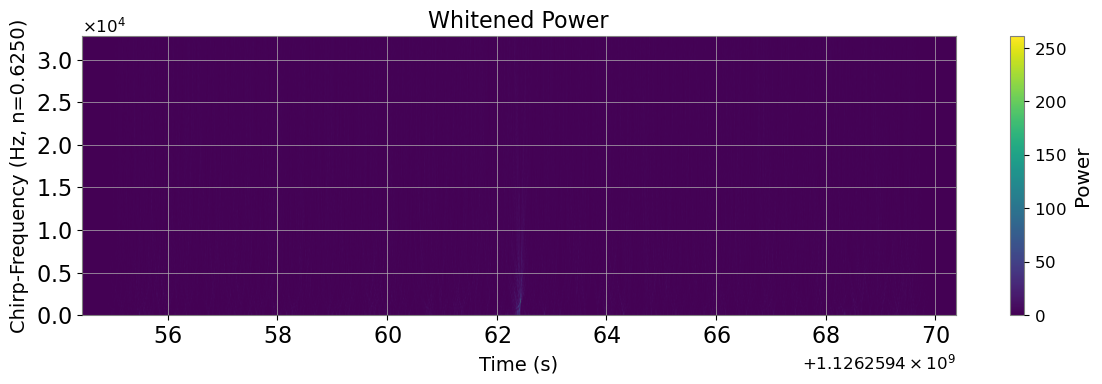

In [11]:
plt.figure(figsize=(12, 4))
plt.imshow(
    np.abs(whitenedTFSignal) ** 2,
    aspect='auto',
    origin='lower',
    cmap='viridis',
    extent=[times[0], times[-1], n_frequency[0], n_frequency[-1]]
)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel(f"Chirp-Frequency (Hz, n={n:.4f})", fontsize=14)
plt.title(r"Whitened Power", fontsize=16)
plt.colorbar(label='Power')
plt.tight_layout()
plt.show()

In [14]:
istpt = ISTPT()

TypeError: ISTPT.__init__() missing 4 required positional arguments: 'n', 'time', 'codomain', and 'window_size'

In [ ]:
reconstruct = istpt.transform(whitenedTFSignal)[0]